In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

models = ['logit']
fs = ["all"]
tickers = ['SPX Index']

plt.style.use('bmh')

In [5]:

for m in models:
    for f in fs:
        for t in tickers:
            df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, m, "indices", "{}.csv".format(t)))



'/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src'

In [20]:
f = "all"
m = "logit"
t = "SPX Index"
df = pd.read_csv(os.path.join(os.getcwd(), "results", "forecast", f, "indices", m, "{}.csv".format(t)))
df.set_index("date", inplace=True)


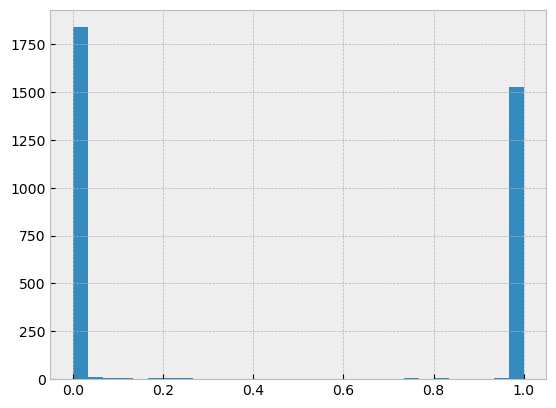

In [21]:
df["prediction"].hist(bins=30)

In [27]:
df.tail()

,return_direction,prediction
date,,
2021-08-25,1,1.000000e+00
2021-08-26,0,1.000000e+00
2021-08-27,1,1.007113e-51
2021-08-30,1,3.326961e-12
2021-08-31,0,5.622762e-135


In [46]:
df.groupby(by=["return_direction"]).count()

,prediction
return_direction,
0,1532
1,1908


### ROC curves and AUC

The roc_curve function from sklearn returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.

In [48]:
buynhold_auc = roc_auc_score(y_true=df["return_direction"], y_score=[1 for _ in range(df.shape[0])])
noskill_auc = roc_auc_score(y_true=df["return_direction"], y_score=[0 for _ in range(df.shape[0])])
model_auc = roc_auc_score(y_true=df["return_direction"], y_score=df["prediction"])

print('Buy n Hold ROC AUC: %.3f' % buynhold_auc)
print('No skill ROC AUC: %.3f' % noskill_auc)
print('Model ROC AUC: %.3f' % model_auc)

Buy n Hold ROC AUC: 0.500
No skill ROC AUC: 0.500
Model ROC AUC: 0.492


Text(0.5, 1.0, 'Logistic vs No skill')

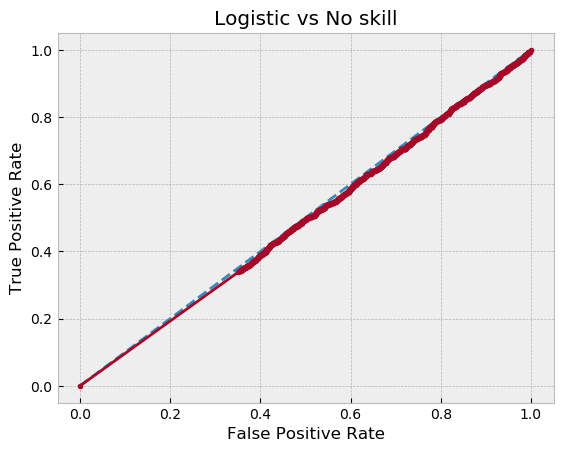

In [54]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [0 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs No skill")

Text(0.5, 1.0, 'Logistic vs Buy n Hold')

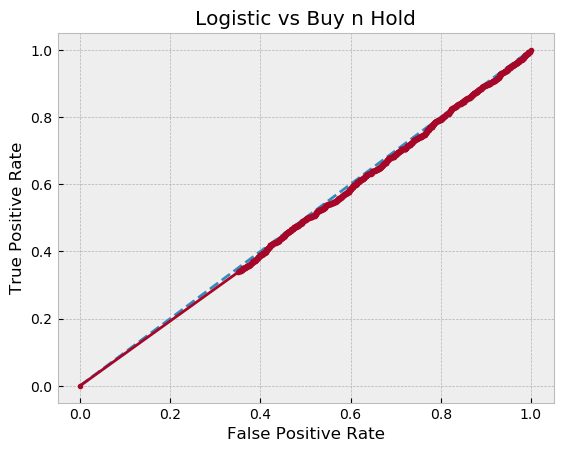

In [53]:
ns_fpr, ns_tpr, _ = roc_curve(df["return_direction"], [1 for _ in range(df.shape[0])])
lr_fpr, lr_tpr, _ = roc_curve(df["return_direction"], df["prediction"])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Buy n hold')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Logistic vs Buy n Hold")